# FUM Computer Vision - Session 06

Visit the [course repository on Github](https://github.com/alifarrokh/FUM-ComputerVision) to get access to other sessions.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from math import floor, ceil, sqrt
import os

import warnings
warnings.filterwarnings("ignore")

# Utils

In [ ]:
def imshow(*args, figsize=10, to_rgb=True, title=None, fontsize=12):
    if isinstance(figsize, int):
        figsize = (figsize, figsize)
    images = args[0] if type(args[0]) is list else list(args)
    if to_rgb:
        images = list(map(lambda x: cv2.cvtColor(x, cv2.COLOR_BGR2RGB), images))
    if title is not None:
        assert len(title) == len(images), "Please provide a title for each image."
    plt.figure(figsize=figsize)
    for i in range(1, len(images)+1):
        plt.subplot(1, len(images), i)
        if title is not None:
            plt.title(title[i-1], fontsize=fontsize)
        plt.imshow(images[i-1])
        plt.axis('off')
    plt.show()

In [ ]:
def normalize(a):
    if isinstance(a, list):
        return list(map(normalize, a))
    if isinstance(a, tuple):
        return tuple(normalize(list(a)))
    values = (((a - a.min()) / (a.max() - a.min())) * 255)
    values = values.astype('uint8')
    return values

# Harris Corner Detector

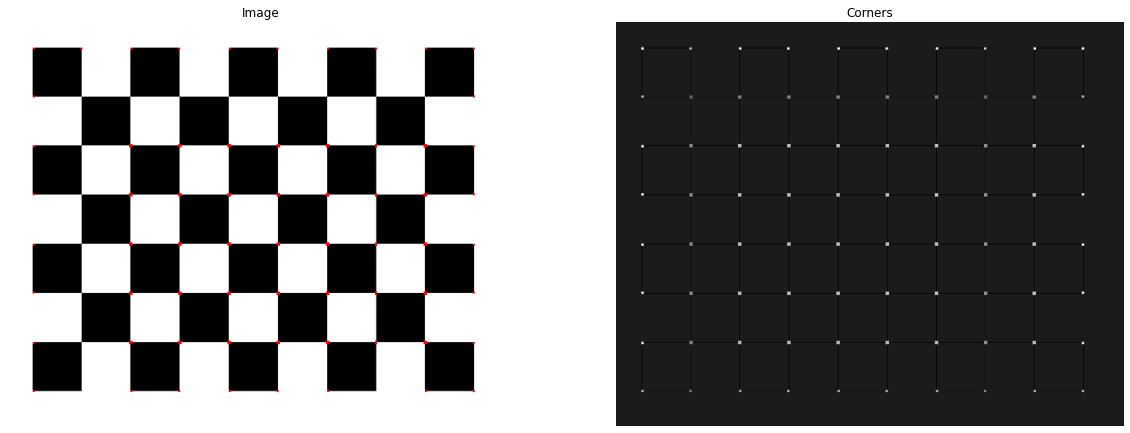

In [ ]:
img_original = cv2.imread('checkerboard.png')
img_original = cv2.resize(img_original, (int(img_original.shape[1]/6), int(img_original.shape[0]/6)))

# The image should be grayscale and float32
img = cv2.cvtColor(img_original, cv2.COLOR_BGR2GRAY).astype('float32')

# Harris corner detector
corners = cv2.cornerHarris(img, blockSize=2, ksize=3, k=0.05)

# Apply dilation to make the corner dots bigger
corners = cv2.dilate(corners, None)

# Threshold
cornsers_thresh = corners > (0.5 * corners.max())
img_original[cornsers_thresh] = [0, 0, 255]

# Display
corners = normalize(corners)
imshow(img_original, corners, title=['Image', 'Corners'], figsize=20)

# SIFT - Creating Panorama Images

In [ ]:
!wget -q "https://cdn.britannica.com/54/75854-050-E27E66C0/Eiffel-Tower-Paris.jpg" -O tower.jpg

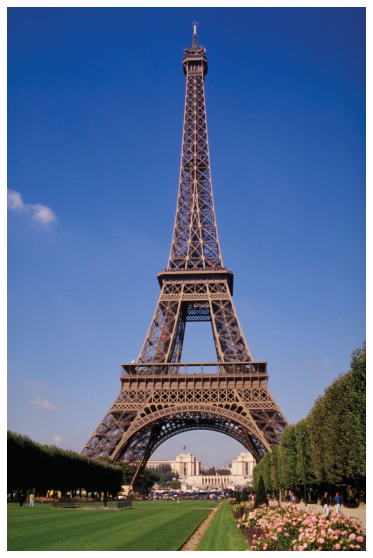

In [ ]:
img = cv2.imread('tower.jpg')
imshow(img)

In [ ]:
def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

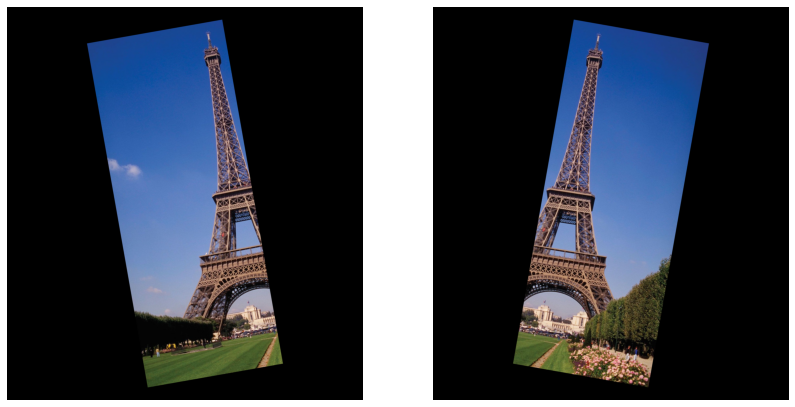

In [ ]:
img = cv2.imread('tower.jpg')

# Create left and right images
height, width, _ = img.shape
left = img[:, :width//2+100]
right = img[:, width//2-100:]

# Rotate the left and right images
padding_x = 1000
padding_y = 200

left_img = np.zeros((left.shape[0]+padding_y, left.shape[1]+padding_x, 3), dtype='uint8')
left_img[padding_y//2:-padding_y//2, padding_x//2:-padding_x//2] = left
left_img = rotate_image(left_img, 10)

right_img = np.zeros((right.shape[0]+padding_y, right.shape[1]+padding_x, 3), dtype='uint8')
right_img[padding_y//2:-padding_y//2, padding_x//2:-padding_x//2] = right
right_img = rotate_image(right_img, -10)

# Display
imshow(left_img, right_img, figsize=14)

3287


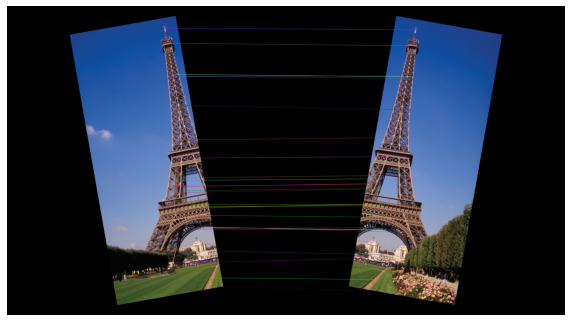

In [ ]:
# Create SIFT instance
sift = cv2.xfeatures2d.SIFT_create()

# Run SIFT on both images
keypoints_l, descriptors_l = sift.detectAndCompute(left_img, None)
keypoints_r, descriptors_r = sift.detectAndCompute(right_img, None)

# Feature matching
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
matches = bf.match(descriptors_l, descriptors_r)
matches = sorted(matches, key=lambda x:x.distance)
print(len(matches))
# Draw matches
matches_img = cv2.drawMatches(
    left_img, keypoints_l,
    right_img, keypoints_r,
    matches[:30],
    None,
    flags=2, # Disable drawing single key points
)
imshow(matches_img)

[[1017.05126953125, 1050.0703125], [1230.7935791015625, 1634.8438720703125], [1135.5093994140625, 1290.856689453125]]
[[532.0220336914062, 1036.21826171875], [532.7582397460938, 1658.6884765625], [560.8875122070312, 1302.80859375]]


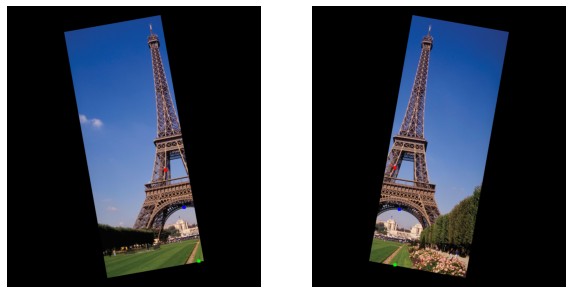

In [ ]:
# Map each match to corresponding keypoints
points = matches[:3]
points = map(lambda m: (keypoints_l[m.queryIdx], keypoints_r[m.trainIdx]), points)

# Map keypoints to coordinates
pts_left = []
pts_right = []
for left_pt, right_pt in points:
    pts_left.append(list(left_pt.pt))
    pts_right.append(list(right_pt.pt))

print(pts_left)
print(pts_right)

# Convert to numpy arrays
pts_left = np.array(pts_left, dtype='float32')
pts_right = np.array(pts_right, dtype='float32')

# Plot points on the images
colors = [[0, 0, 255], [0, 255, 0], [255, 0, 0]]

right_img_pts = right_img.copy()
for i, (x, y) in enumerate(pts_right):
    x, y = int(x), int(y)
    right_img_pts[y-10:y+10, x-10:x+10, :] = colors[i]

left_img_pts = left_img.copy()
for i, (x, y) in enumerate(pts_left):
    x, y = int(x), int(y)
    left_img_pts[y-10:y+10, x-10:x+10, :] = colors[i]

# Plot the results
imshow(left_img_pts, right_img_pts)

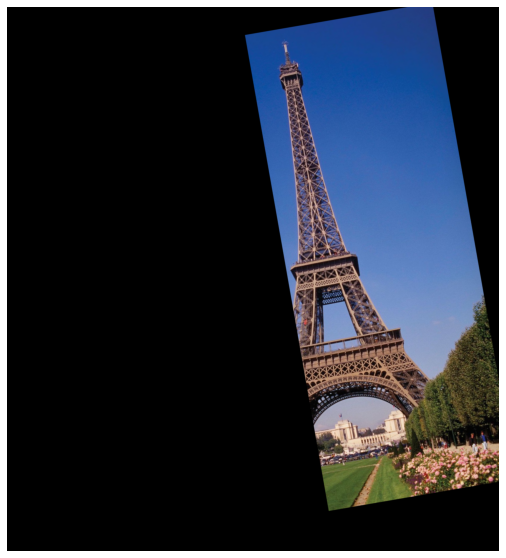

In [ ]:
# Create affine transformation matrix
M = cv2.getAffineTransform(pts_right, pts_left)
right_image_transformed = cv2.warpAffine(right_img, M, (right_img.shape[1], right_img.shape[0]))

imshow(right_image_transformed)

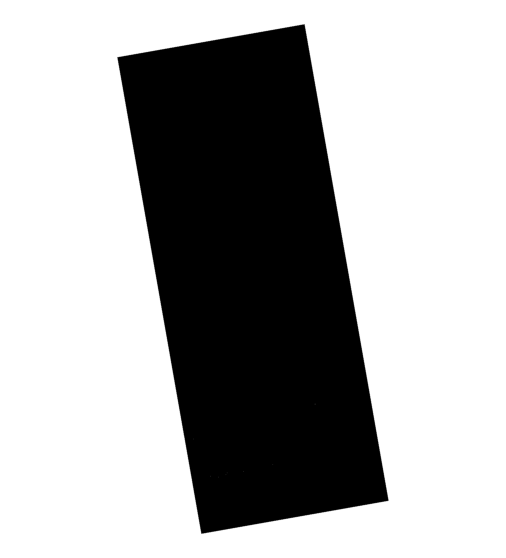

In [ ]:
# Create a mask
mask = np.all((left_img == 0), axis=2)
result = np.zeros_like(left_img)
result[mask] = 255

imshow(result)

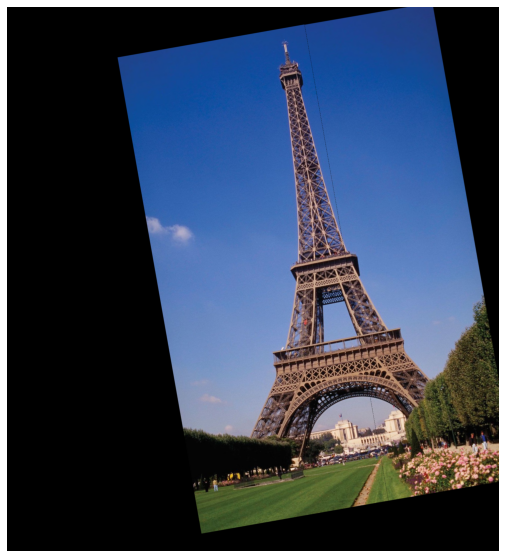

In [ ]:
# Merge the images
full_mask = np.repeat(mask.reshape(mask.shape+(1,)), 3, axis=2)
result = left_img + (full_mask * right_image_transformed)
imshow(result)

# ORB (Oriented FAST and rotated BRIEF)

Descriptor Size: 500


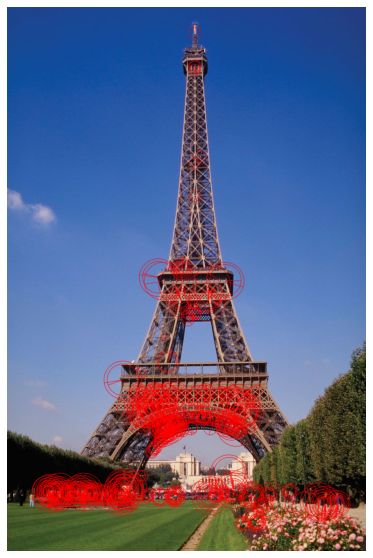

In [ ]:
orb = cv2.ORB_create()

img = cv2.imread('tower.jpg')
keypoints, descriptors = orb.detectAndCompute(img, None)

print(f'Descriptor Size: {len(descriptors)}')

keypoints_img = cv2.drawKeypoints(img, keypoints, None, (0,0,255), 4)

imshow(keypoints_img)

# Simple Image Classification

In [ ]:
def img_distance(img1, img2):
    sift = cv2.xfeatures2d.SIFT_create()

    keypoints_1, descriptors_1 = sift.detectAndCompute(img1, None)
    keypoints_2, descriptors_2 = sift.detectAndCompute(img2, None)

    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
    matches = bf.match(descriptors_1, descriptors_2)
    matches = sorted(matches, key=lambda x:x.distance)
    limit = min(len(matches), 5)
    matches = matches[:limit]

    distance = map(lambda x: x.distance, matches)
    distance = sum(list(distance)) / limit

    return distance

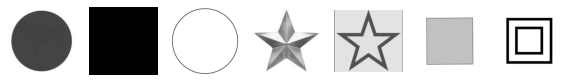

In [ ]:
images = os.listdir('shapes')
images.remove('star2.jpg')
images = list(map(lambda name: cv2.imread(f'shapes/{name}', cv2.IMREAD_GRAYSCALE), images))

imshow(images)

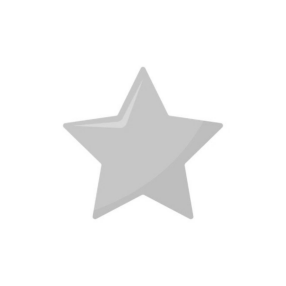

In [ ]:
star = cv2.imread('shapes/star2.jpg', cv2.IMREAD_GRAYSCALE)
imshow(star, figsize=5)

Failed: 2


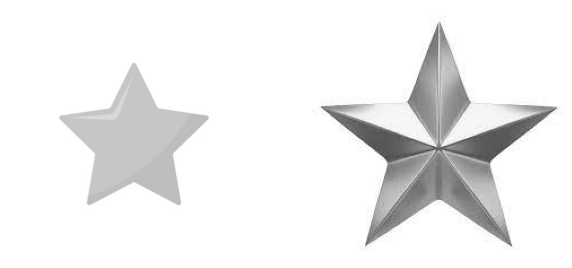

In [ ]:
min_d = np.inf
closest = None
failed = 0

for img in images:
    try:
        d = img_distance(star, img)
    except Exception as e:
        failed += 1
        continue
    if d < min_d:
        min_d = d
        closest = img

print('Failed:', failed)
imshow(star, closest)